In [75]:
!which python

/home/paperspace/anaconda3/envs/fastai/bin/python


In [2]:
import enum
import math
import pdb
import platform
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook

from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TrainPascalFlatDataset, device
from ssdmultibox.models import SSDModel
from ssdmultibox import utils

import matplotlib.pyplot as plt
plt.ion()

In [3]:
device

device(type='cuda', index=0)

In [4]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [5]:
model = SSDModel().to(device)

In [6]:
LR = 1e-2
SSD_LOSS_ALPHA = .2

criterion = SSDLoss(alpha=SSD_LOSS_ALPHA)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
current_time = time.time()

In [7]:
train_dataset = TrainPascalFlatDataset()

len(train_dataset)

2501

In [8]:
NUM_WORKERS = utils.get_cpu_count()

if platform.system() == 'Darwin': # Mac
    BATCH = 4
    SHUFFLE = False
else:
    BATCH = 32
    SHUFFLE = True
    
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

vars(dataloader)

{'dataset': <ssdmultibox.datasets.TrainPascalFlatDataset at 0x7f1445e6fda0>,
 'batch_size': 32,
 'num_workers': 8,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f1445e9eef0>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f1445e9efd0>,
 '_DataLoader__initialized': True}

In [9]:
EPOCHS = 9

for epoch in range(EPOCHS):
    scheduler.step()
    steps = math.ceil(len(train_dataset) / BATCH)
    for step in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(ims)
        loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        if step % 5 == 0:
            print('epoch: {} step: {} loss: {:.4f} time: {:.4f}'.format(
                epoch, step, loss.item(), time.time() - current_time))
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())

pos_loss: 584.5266 neg_hard_mining_loss: 1841.0157
n: 192.0 bbs_loss: 1999.6644 cats_loss: 2425.5425
epoch: 0 step: 0 loss: 23.0480 time: 3.8353
pos_loss: 462.6898 neg_hard_mining_loss: 1444.3440
n: 152.0 bbs_loss: 2535.2878 cats_loss: 1907.0341
pos_loss: 843.2793 neg_hard_mining_loss: 2594.4033
n: 277.0 bbs_loss: 3565.1724 cats_loss: 3437.6826
pos_loss: 928.3896 neg_hard_mining_loss: 2820.5554
n: 305.0 bbs_loss: 3098.1594 cats_loss: 3748.9453
pos_loss: 815.7151 neg_hard_mining_loss: 2465.2781
n: 268.0 bbs_loss: 3457.3523 cats_loss: 3280.9934
pos_loss: 661.0751 neg_hard_mining_loss: 1990.6631
n: 217.0 bbs_loss: 3042.4763 cats_loss: 2651.7380
epoch: 0 step: 5 loss: 26.2406 time: 12.6798
pos_loss: 599.8496 neg_hard_mining_loss: 1804.7709
n: 197.0 bbs_loss: 2736.0593 cats_loss: 2404.6206
pos_loss: 800.3585 neg_hard_mining_loss: 2404.8657
n: 263.0 bbs_loss: 3231.0840 cats_loss: 3205.2249
pos_loss: 961.7422 neg_hard_mining_loss: 2883.2039
n: 316.0 bbs_loss: 3745.9382 cats_loss: 3844.9460
po

pos_loss: 918.5557 neg_hard_mining_loss: 1597.6798
n: 302.0 bbs_loss: 3000.6802 cats_loss: 2516.2363
epoch: 0 step: 75 loss: 18.2679 time: 12.6573
pos_loss: 653.5482 neg_hard_mining_loss: 1140.8821
n: 216.0 bbs_loss: 2341.6536 cats_loss: 1794.4304
pos_loss: 689.7982 neg_hard_mining_loss: 1203.5255
n: 230.0 bbs_loss: 2876.4766 cats_loss: 1893.3236
pos_loss: 616.3259 neg_hard_mining_loss: 1095.7589
n: 213.0 bbs_loss: 3029.8389 cats_loss: 1712.0846



pos_loss: 768.2383 neg_hard_mining_loss: 1241.0646
n: 245.0 bbs_loss: 2957.4226 cats_loss: 2009.3026
epoch: 1 step: 0 loss: 20.2723 time: 10.8799
pos_loss: 646.8661 neg_hard_mining_loss: 1012.0302
n: 200.0 bbs_loss: 2658.1245 cats_loss: 1658.8961
pos_loss: 681.0983 neg_hard_mining_loss: 1221.0376
n: 250.0 bbs_loss: 3127.1721 cats_loss: 1902.1359
pos_loss: 875.8212 neg_hard_mining_loss: 1412.8702
n: 296.0 bbs_loss: 3805.9343 cats_loss: 2288.6909
pos_loss: 492.8777 neg_hard_mining_loss: 729.6111
n: 153.0 bbs_loss: 1481.2372 cats_loss: 1222.4888
pos_loss: 595.1333 neg_hard_mining_loss: 884.3125
n: 189.0 bbs_loss: 2514.3618 cats_loss: 1479.4454
epoch: 1 step: 5 loss: 21.1313 time: 12.8571
pos_loss: 732.1838 neg_hard_mining_loss: 1138.0511
n: 251.0 bbs_loss: 3120.5603 cats_loss: 1870.2349
pos_loss: 769.1569 neg_hard_mining_loss: 1069.3240
n: 237.0 bbs_loss: 2762.7693 cats_loss: 1838.4811
pos_loss: 923.4677 neg_hard_mining_loss: 1326.5680
n: 304.0 bbs_loss: 3113.2319 cats_loss: 2250.0361
pos

pos_loss: 860.4799 neg_hard_mining_loss: 506.2144
n: 284.0 bbs_loss: 3420.9355 cats_loss: 1366.6943
epoch: 1 step: 75 loss: 16.8579 time: 13.1882
pos_loss: 1008.6697 neg_hard_mining_loss: 503.1809
n: 291.0 bbs_loss: 2973.7629 cats_loss: 1511.8508
pos_loss: 881.8234 neg_hard_mining_loss: 396.1093
n: 232.0 bbs_loss: 2401.4871 cats_loss: 1277.9329
pos_loss: 916.7137 neg_hard_mining_loss: 410.6828
n: 243.0 bbs_loss: 2334.1006 cats_loss: 1327.3961



pos_loss: 925.7888 neg_hard_mining_loss: 433.6884
n: 264.0 bbs_loss: 2841.9556 cats_loss: 1359.4771
epoch: 2 step: 0 loss: 15.9145 time: 10.9952
pos_loss: 678.7477 neg_hard_mining_loss: 325.7593
n: 190.0 bbs_loss: 2504.5251 cats_loss: 1004.5069
pos_loss: 935.4565 neg_hard_mining_loss: 469.7996
n: 259.0 bbs_loss: 2932.3491 cats_loss: 1405.2561
pos_loss: 964.1174 neg_hard_mining_loss: 527.3013
n: 283.0 bbs_loss: 3311.9595 cats_loss: 1491.4183
pos_loss: 890.1393 neg_hard_mining_loss: 480.0528
n: 265.0 bbs_loss: 3115.1338 cats_loss: 1370.1919
pos_loss: 959.0769 neg_hard_mining_loss: 495.6484
n: 304.0 bbs_loss: 3465.7532 cats_loss: 1454.7252
epoch: 2 step: 5 loss: 16.1858 time: 12.8531
pos_loss: 897.7495 neg_hard_mining_loss: 393.8672
n: 242.0 bbs_loss: 3143.8132 cats_loss: 1291.6166
pos_loss: 813.6613 neg_hard_mining_loss: 348.8800
n: 219.0 bbs_loss: 2433.2422 cats_loss: 1162.5414
pos_loss: 850.1506 neg_hard_mining_loss: 382.8240
n: 236.0 bbs_loss: 3257.8792 cats_loss: 1232.9747
pos_loss: 

epoch: 2 step: 75 loss: 16.6034 time: 12.7754
pos_loss: 996.4066 neg_hard_mining_loss: 351.0174
n: 292.0 bbs_loss: 3391.5066 cats_loss: 1347.4238
pos_loss: 804.7610 neg_hard_mining_loss: 253.7832
n: 205.0 bbs_loss: 2110.6521 cats_loss: 1058.5443
pos_loss: 879.9318 neg_hard_mining_loss: 287.1313
n: 248.0 bbs_loss: 2934.6555 cats_loss: 1167.0627



pos_loss: 1131.9773 neg_hard_mining_loss: 364.5599
n: 310.0 bbs_loss: 3400.2239 cats_loss: 1496.5374
epoch: 3 step: 0 loss: 15.7960 time: 10.1628
pos_loss: 848.8370 neg_hard_mining_loss: 258.3769
n: 216.0 bbs_loss: 2734.4001 cats_loss: 1107.2137
pos_loss: 885.8135 neg_hard_mining_loss: 283.5271
n: 249.0 bbs_loss: 3180.5212 cats_loss: 1169.3407
pos_loss: 894.9084 neg_hard_mining_loss: 287.1092
n: 255.0 bbs_loss: 2600.2183 cats_loss: 1182.0176
pos_loss: 742.2533 neg_hard_mining_loss: 238.5537
n: 210.0 bbs_loss: 2667.8723 cats_loss: 980.8070
pos_loss: 767.5736 neg_hard_mining_loss: 242.2885
n: 215.0 bbs_loss: 2695.4768 cats_loss: 1009.8620
epoch: 3 step: 5 loss: 17.2341 time: 13.2352
pos_loss: 589.0786 neg_hard_mining_loss: 188.5758
n: 167.0 bbs_loss: 2052.5371 cats_loss: 777.6542
pos_loss: 1017.3972 neg_hard_mining_loss: 323.8577
n: 291.0 bbs_loss: 3165.5486 cats_loss: 1341.2550
pos_loss: 957.3781 neg_hard_mining_loss: 287.6082
n: 248.0 bbs_loss: 2941.4258 cats_loss: 1244.9865
pos_loss: 

epoch: 3 step: 75 loss: 17.0749 time: 12.0125
pos_loss: 1146.1046 neg_hard_mining_loss: 327.6608
n: 309.0 bbs_loss: 3495.8328 cats_loss: 1473.7654
pos_loss: 849.6791 neg_hard_mining_loss: 264.4353
n: 249.0 bbs_loss: 2675.7351 cats_loss: 1114.1143
pos_loss: 911.2570 neg_hard_mining_loss: 275.8798
n: 256.0 bbs_loss: 3185.1843 cats_loss: 1187.1367



pos_loss: 951.0323 neg_hard_mining_loss: 290.5597
n: 270.0 bbs_loss: 3347.8677 cats_loss: 1241.5919
epoch: 4 step: 0 loss: 16.9980 time: 10.5684
pos_loss: 747.4816 neg_hard_mining_loss: 238.5323
n: 223.0 bbs_loss: 2884.4951 cats_loss: 986.0138
pos_loss: 853.5723 neg_hard_mining_loss: 252.6736
n: 238.0 bbs_loss: 2877.6196 cats_loss: 1106.2460
pos_loss: 815.1638 neg_hard_mining_loss: 247.1299
n: 228.0 bbs_loss: 2473.1875 cats_loss: 1062.2936
pos_loss: 876.5755 neg_hard_mining_loss: 257.9674
n: 242.0 bbs_loss: 2672.7205 cats_loss: 1134.5427
pos_loss: 1213.9120 neg_hard_mining_loss: 364.6111
n: 345.0 bbs_loss: 3545.4199 cats_loss: 1578.5233
epoch: 4 step: 5 loss: 14.8520 time: 12.7948
pos_loss: 1053.3678 neg_hard_mining_loss: 299.0261
n: 282.0 bbs_loss: 3172.6072 cats_loss: 1352.3939
pos_loss: 908.3782 neg_hard_mining_loss: 242.7084
n: 229.0 bbs_loss: 2870.1665 cats_loss: 1151.0867
pos_loss: 858.7613 neg_hard_mining_loss: 253.6100
n: 239.0 bbs_loss: 2916.8103 cats_loss: 1112.3713
pos_loss:

epoch: 4 step: 75 loss: 16.1113 time: 12.4872
pos_loss: 812.1689 neg_hard_mining_loss: 234.9603
n: 220.0 bbs_loss: 2743.4526 cats_loss: 1047.1293
pos_loss: 1101.4235 neg_hard_mining_loss: 321.1253
n: 307.0 bbs_loss: 4048.9380 cats_loss: 1422.5486
pos_loss: 817.1283 neg_hard_mining_loss: 229.3922
n: 216.0 bbs_loss: 2519.0876 cats_loss: 1046.5205



pos_loss: 859.8973 neg_hard_mining_loss: 255.9638
n: 244.0 bbs_loss: 2499.1023 cats_loss: 1115.8612
epoch: 5 step: 0 loss: 14.8154 time: 10.7263
pos_loss: 749.2131 neg_hard_mining_loss: 220.0952
n: 209.0 bbs_loss: 2736.5305 cats_loss: 969.3083
pos_loss: 807.3521 neg_hard_mining_loss: 233.5156
n: 221.0 bbs_loss: 2614.8494 cats_loss: 1040.8677
pos_loss: 932.8630 neg_hard_mining_loss: 290.7915
n: 280.0 bbs_loss: 3203.4089 cats_loss: 1223.6545
pos_loss: 1062.0355 neg_hard_mining_loss: 295.5404
n: 280.0 bbs_loss: 3269.9041 cats_loss: 1357.5762
pos_loss: 794.8095 neg_hard_mining_loss: 224.7615
n: 216.0 bbs_loss: 2835.3308 cats_loss: 1019.5709
epoch: 5 step: 5 loss: 17.8468 time: 12.1561
pos_loss: 1088.7830 neg_hard_mining_loss: 298.0060
n: 275.0 bbs_loss: 3302.2583 cats_loss: 1386.7891
pos_loss: 889.1112 neg_hard_mining_loss: 271.7193
n: 260.0 bbs_loss: 3364.6960 cats_loss: 1160.8306
pos_loss: 891.2242 neg_hard_mining_loss: 283.1995
n: 269.0 bbs_loss: 2797.5388 cats_loss: 1174.4236
pos_loss:

epoch: 5 step: 75 loss: 17.3622 time: 12.0095
pos_loss: 677.8199 neg_hard_mining_loss: 190.3624
n: 178.0 bbs_loss: 2569.4565 cats_loss: 868.1822
pos_loss: 797.3287 neg_hard_mining_loss: 263.2062
n: 251.0 bbs_loss: 3063.3472 cats_loss: 1060.5349
pos_loss: 909.2501 neg_hard_mining_loss: 242.9203
n: 231.0 bbs_loss: 2663.6638 cats_loss: 1152.1704



pos_loss: 1008.7106 neg_hard_mining_loss: 278.6421
n: 266.0 bbs_loss: 3183.5879 cats_loss: 1287.3529
epoch: 6 step: 0 loss: 16.8080 time: 9.9851
pos_loss: 842.5842 neg_hard_mining_loss: 227.3698
n: 216.0 bbs_loss: 2715.8076 cats_loss: 1069.9542
pos_loss: 818.3864 neg_hard_mining_loss: 230.7459
n: 213.0 bbs_loss: 2724.3667 cats_loss: 1049.1323
pos_loss: 1016.0562 neg_hard_mining_loss: 288.5615
n: 276.0 bbs_loss: 3127.8352 cats_loss: 1304.6177
pos_loss: 762.3405 neg_hard_mining_loss: 218.7816
n: 208.0 bbs_loss: 2777.4224 cats_loss: 981.1222
pos_loss: 720.4554 neg_hard_mining_loss: 189.1067
n: 180.0 bbs_loss: 2731.2080 cats_loss: 909.5621
epoch: 6 step: 5 loss: 20.2265 time: 12.1757
pos_loss: 865.3912 neg_hard_mining_loss: 264.3631
n: 250.0 bbs_loss: 3688.5571 cats_loss: 1129.7544
pos_loss: 882.8923 neg_hard_mining_loss: 241.0722
n: 230.0 bbs_loss: 2752.4153 cats_loss: 1123.9647
pos_loss: 1040.1610 neg_hard_mining_loss: 316.4431
n: 304.0 bbs_loss: 3542.0664 cats_loss: 1356.6042
pos_loss: 

epoch: 6 step: 75 loss: 19.5630 time: 11.9463
pos_loss: 781.7393 neg_hard_mining_loss: 215.9660
n: 205.0 bbs_loss: 2807.0710 cats_loss: 997.7056
pos_loss: 1181.7748 neg_hard_mining_loss: 339.6320
n: 323.0 bbs_loss: 3032.5779 cats_loss: 1521.4071
pos_loss: 776.2707 neg_hard_mining_loss: 227.9970
n: 213.0 bbs_loss: 2374.8550 cats_loss: 1004.2675



pos_loss: 756.8027 neg_hard_mining_loss: 219.8105
n: 209.0 bbs_loss: 2300.7000 cats_loss: 976.6133
epoch: 7 step: 0 loss: 15.6809 time: 9.8220
pos_loss: 933.6890 neg_hard_mining_loss: 265.2400
n: 252.0 bbs_loss: 2753.7493 cats_loss: 1198.9290
pos_loss: 860.6885 neg_hard_mining_loss: 279.2159
n: 264.0 bbs_loss: 2920.6321 cats_loss: 1139.9043
pos_loss: 1000.6450 neg_hard_mining_loss: 299.3835
n: 286.0 bbs_loss: 3208.5122 cats_loss: 1300.0286
pos_loss: 824.4997 neg_hard_mining_loss: 223.8328
n: 203.0 bbs_loss: 2218.3489 cats_loss: 1048.3325
pos_loss: 974.6773 neg_hard_mining_loss: 286.0261
n: 272.0 bbs_loss: 3201.5344 cats_loss: 1260.7032
epoch: 7 step: 5 loss: 16.4053 time: 12.5807
pos_loss: 689.9329 neg_hard_mining_loss: 205.0866
n: 194.0 bbs_loss: 2163.9763 cats_loss: 895.0194
pos_loss: 862.6387 neg_hard_mining_loss: 255.1420
n: 242.0 bbs_loss: 2697.1133 cats_loss: 1117.7805
pos_loss: 1233.8679 neg_hard_mining_loss: 337.3535
n: 322.0 bbs_loss: 2327.9043 cats_loss: 1571.2214
pos_loss: 7

epoch: 7 step: 75 loss: 18.2514 time: 12.4492
pos_loss: 787.5173 neg_hard_mining_loss: 240.4427
n: 228.0 bbs_loss: 2990.9370 cats_loss: 1027.9600
pos_loss: 939.8879 neg_hard_mining_loss: 253.9168
n: 242.0 bbs_loss: 2593.7039 cats_loss: 1193.8049
pos_loss: 773.4301 neg_hard_mining_loss: 218.5943
n: 206.0 bbs_loss: 2714.7446 cats_loss: 992.0244



pos_loss: 973.8287 neg_hard_mining_loss: 280.7215
n: 266.0 bbs_loss: 3018.6882 cats_loss: 1254.5502
epoch: 8 step: 0 loss: 16.0648 time: 9.7779
pos_loss: 1072.5505 neg_hard_mining_loss: 298.6757
n: 283.0 bbs_loss: 3149.2969 cats_loss: 1371.2260
pos_loss: 826.0342 neg_hard_mining_loss: 252.6186
n: 241.0 bbs_loss: 3152.1658 cats_loss: 1078.6530
pos_loss: 809.2968 neg_hard_mining_loss: 245.4696
n: 223.0 bbs_loss: 2588.8914 cats_loss: 1054.7662
pos_loss: 724.4412 neg_hard_mining_loss: 199.2526
n: 189.0 bbs_loss: 2412.2566 cats_loss: 923.6937
pos_loss: 761.1123 neg_hard_mining_loss: 219.1694
n: 204.0 bbs_loss: 2248.5547 cats_loss: 980.2817
epoch: 8 step: 5 loss: 15.8276 time: 12.4394
pos_loss: 923.8168 neg_hard_mining_loss: 273.7810
n: 254.0 bbs_loss: 2860.7368 cats_loss: 1197.5978
pos_loss: 857.1301 neg_hard_mining_loss: 245.0390
n: 233.0 bbs_loss: 2883.6638 cats_loss: 1102.1692
pos_loss: 904.9454 neg_hard_mining_loss: 243.6006
n: 233.0 bbs_loss: 2621.8594 cats_loss: 1148.5461
pos_loss: 86

epoch: 8 step: 75 loss: 17.2862 time: 12.2598
pos_loss: 1106.1282 neg_hard_mining_loss: 313.1368
n: 304.0 bbs_loss: 3258.2654 cats_loss: 1419.2650
pos_loss: 993.0188 neg_hard_mining_loss: 296.1917
n: 282.0 bbs_loss: 2752.8193 cats_loss: 1289.2104
pos_loss: 893.9352 neg_hard_mining_loss: 242.7798
n: 227.0 bbs_loss: 2864.5261 cats_loss: 1136.7151



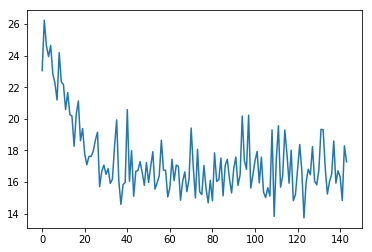

In [19]:
plt.plot(losses['total'])

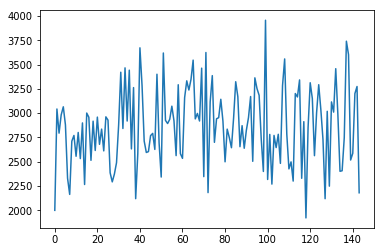

In [20]:
plt.plot(losses['loc'])

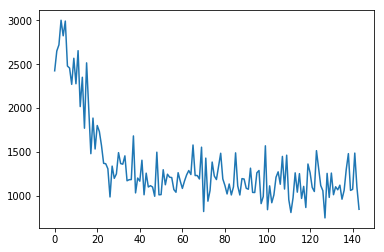

In [21]:
plt.plot(losses['conf'])

In [22]:
utils.save_model(model)

model saved at: model_checkpoints/model-2018-12-09T15:42:29.cpkt


In [23]:
bbs_preds, cats_preds = preds

In [24]:
from ssdmultibox.plotting import *

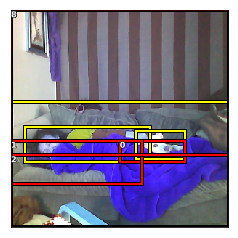

In [72]:
idx = 0
dataset = train_dataset

plot_anchor_bbs(dataset, image_ids, idx, gt_cats)

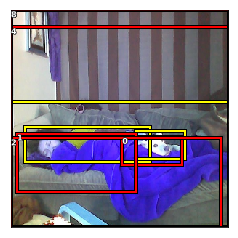

In [73]:
plot_preds(dataset, image_ids, idx, bbs_preds, gt_cats)

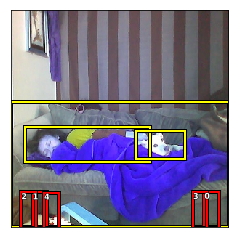

In [74]:
plot_nms_preds(dataset, image_ids, idx, preds, limit=5)

In [56]:
boxes, scores, cls_ids = Predict.all(preds, index=idx)

for x in [boxes, scores, cls_ids]:
    print(x[:5])

tensor([[  0.0000, 267.0520,  48.7013, 286.6442],
        [  0.0000,  14.6095,  48.5382,  34.1743],
        [251.2200,  14.7824, 300.0000,  33.9818],
        [188.1209, 267.0498, 238.0530, 286.6447],
        [156.5683, 267.0873, 206.3918, 286.5921]], device='cuda:0')
tensor([3.9989, 3.9116, 3.8170, 3.7773, 3.7000], device='cuda:0')
tensor([14, 14, 14, 14, 14], device='cuda:0')


In [65]:
mask = gt_cats[idx] != 20
mask.shape

torch.Size([11640])

In [66]:
gt_cats[idx][mask]

tensor([20, 20, 20, 20, 20, 20, 20, 20, 20], device='cuda:0')

In [70]:
idx = 0
cat_mask = gt_cats[idx] != 20
cat_mask.sum()

tensor(9, device='cuda:0')

In [71]:
gt_cats[idx][cat_mask]

tensor([11, 14, 17, 17, 17, 17, 17, 17, 17], device='cuda:0')

In [69]:
mask = gt_cats != 20
gt_cats[mask]

tensor([11, 14, 17, 17, 17, 17, 17, 17, 17,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10,
        10, 10, 10, 10,  8,  0,  0,  7,  7,  7,  7,  7,  7,  2,  1,  1,  1,  1,
         1,  1, 15, 15, 19, 19, 19, 19, 19, 19, 19, 19, 11, 11, 11, 11, 11, 11,
        11,  0, 14, 14,  6, 19, 14, 14, 14, 14, 19,  8,  1,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  1,  8,  1,  8,  1,  8,  8,  8,  8,  8,  8,  8,
         8, 16, 16, 16, 16, 16, 16,  6,  6,  6,  6, 14,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  0,  0,  0,  0,  6, 12, 12, 12, 12, 12, 12,  6,  6,  6,  6,
         6,  6,  4,  4,  8,  8, 17, 14,  2,  2,  2, 14, 14, 14, 14, 14, 14, 14,
        19, 19, 17, 17, 17, 19, 19, 19, 17, 17, 17, 17,  5,  5,  8,  8,  8, 17,
         8,  8,  8, 17,  8, 17,  8,  8, 14, 14, 14, 13,  5,  5,  5,  5,  2,  2,
         2,  2,  2,  2,  2, 14, 14, 14, 14, 14, 14,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4, 11, 11, 11, 

In [50]:
cat_names = train_dataset.categories()

In [51]:
cls_ids

tensor([14, 14, 14, 14, 14,  6, 14,  6, 14, 14,  6, 14,  6, 14, 14, 14,  6,  6,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14,  6, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
         6, 14, 14,  6, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  6, 14,  6,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  6, 14, 14, 14, 14,  6,  6, 14,
         6, 14,  6, 14,  6, 14, 14, 14, 14, 14, 14, 14, 14,  6, 14,  6, 14, 14,
        14, 14,  6, 14, 14, 14,  6, 14, 14, 14,  6,  6, 14,  6, 14,  6, 14, 14,
         6,  6,  6,  6, 14, 14, 14, 14, 14, 14,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6, 

In [41]:
cat_names

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor',
 20: 'bg'}

In [42]:
mask = gt_cats != 20
mask.sum()

tensor(227, device='cuda:0')

In [43]:
gt_cats[mask]

tensor([11, 14, 17, 17, 17, 17, 17, 17, 17,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10,
        10, 10, 10, 10,  8,  0,  0,  7,  7,  7,  7,  7,  7,  2,  1,  1,  1,  1,
         1,  1, 15, 15, 19, 19, 19, 19, 19, 19, 19, 19, 11, 11, 11, 11, 11, 11,
        11,  0, 14, 14,  6, 19, 14, 14, 14, 14, 19,  8,  1,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  1,  8,  1,  8,  1,  8,  8,  8,  8,  8,  8,  8,
         8, 16, 16, 16, 16, 16, 16,  6,  6,  6,  6, 14,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  0,  0,  0,  0,  6, 12, 12, 12, 12, 12, 12,  6,  6,  6,  6,
         6,  6,  4,  4,  8,  8, 17, 14,  2,  2,  2, 14, 14, 14, 14, 14, 14, 14,
        19, 19, 17, 17, 17, 19, 19, 19, 17, 17, 17, 17,  5,  5,  8,  8,  8, 17,
         8,  8,  8, 17,  8, 17,  8,  8, 14, 14, 14, 13,  5,  5,  5,  5,  2,  2,
         2,  2,  2,  2,  2, 14, 14, 14, 14, 14, 14,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4, 11, 11, 11, 